<a href="https://colab.research.google.com/github/Zachary-Fernandes/CSCI-6962/blob/main/fernazHW5v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5
#####Zachary Fernandes
#####Projects in Machine Learning and AI

### The Problem

The problem I wanted to understand was determining whether or not a person was wearing a mask based on an image of that person. To do this, I needed to train convolutional neural networks on an [image dataset](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset) of people wearing masks. I need convolutional neural networks because they excel in image processing. Determining if someone is wearing a mask requires images as this is the most direct means of capturing them wearing one, and to ensure it can predict well, we must use a large dataset like that which I linked. I will use the TensorFlow/Keras frameworks to build the necessary CNN models.

In [ ]:
!pip install imbalanced-learn
!pip install graphviz
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-xupbiix3
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-xupbiix3
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184397 sha256=c7a83c717ffae3f031750f6365139823ead32833f2e93fc32ce75eb4bee52f6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-7t3_gtgy/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn import utils

import tensorflow as tf
from tensorflow import feature_column
from tensorflow import keras
import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import IPython
import IPython.display

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from imblearn.over_sampling import SMOTE
import warnings

warnings.filterwarnings("ignore")

import os
import zipfile

import glob
import imageio
import PIL
import tensorflow_probability as tfp
import time
import tensorflow_docs.vis.embed as embed

from scipy import ndimage, misc
import cv2

### Exploratory Data Analysis
Below are the steps I take to perform Exploratory Data Analysis.

#### Getting the Data
This dataset is 346 MB in size. I do not want to reload it every time I get disconnected. Thus, I stored it on Google Drive and pulled it from a mounted Drive. To test it on your own, you will need to do this.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data source: https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset

Data Dictionary/Information

https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/facemask')

In [ ]:
base_dir = '/content/facemask/Face Mask Dataset'
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')

In [ ]:
os.listdir(base_dir)

['Train', 'Validation', 'Test']

### Data Preparation

The instructions on [this site](https://cnvrg.io/cnn-tensorflow/) aided me in preparing the data for the CNN. Since the files are placed in folders for train, test, and validation sets alongside folders for whether or not someone is wearing a mask, we do not need to worry about creating our own train-test-val sets. Below are the sizes for each.

train: 10000 - 84.8%

test: 992 - 8.4%

val: 800 - 6.8%

In [ ]:
# First, we store the images in datasets upscaling each to a constant size of
# 224x224 and setting 32 images in each batch

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

Found 10000 files belonging to 2 classes.


In [ ]:
train_set

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
val_set = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

Found 800 files belonging to 2 classes.


In [ ]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

Found 992 files belonging to 2 classes.


In [ ]:
class_names = train_set.class_names
class_names

['WithMask', 'WithoutMask']

#### Exploring Data - Showing Images

I used this page from [TensorFlow's documentation](https://www.tensorflow.org/tutorials/load_data/images#visualize_the_data) to help display the images.

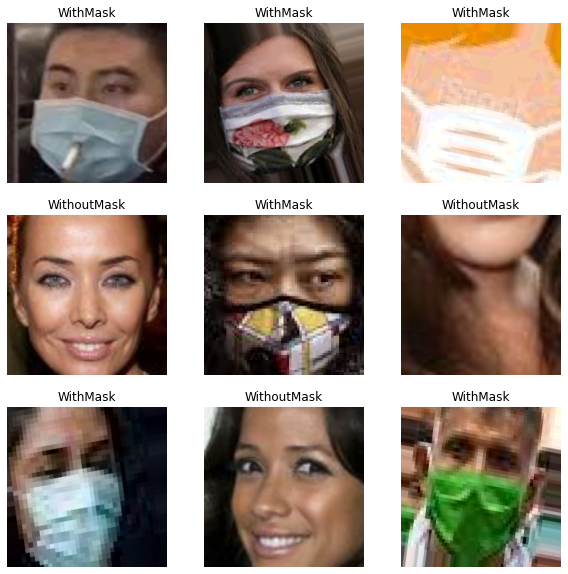

In [ ]:
# viewing the first few rows of the data
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

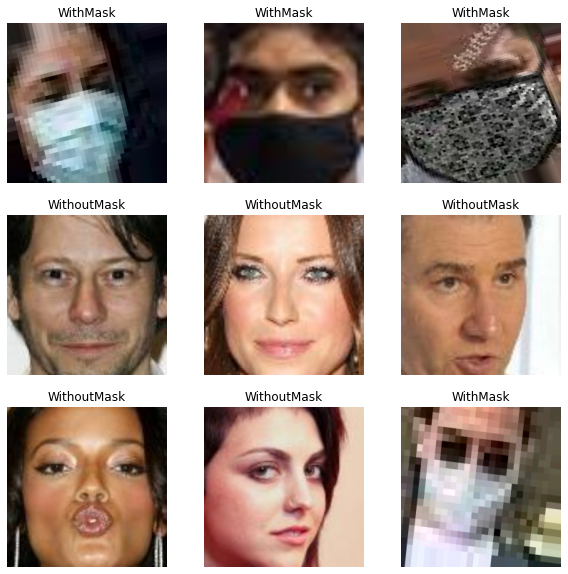

In [ ]:
# viewing the first few rows of the data
plt.figure(figsize=(10, 10))
for images, labels in val_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

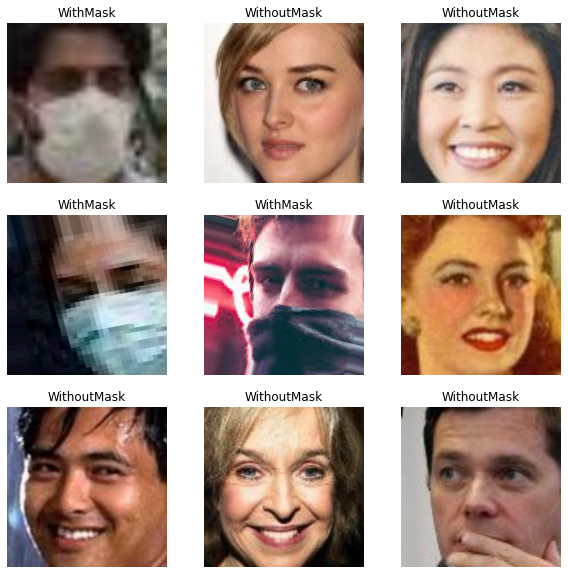

In [ ]:
# viewing the first few rows of the data
plt.figure(figsize=(10, 10))
for images, labels in test_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# We must normalize these images before the neural network processes them
# (this is handled directly in the model)
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
# Early stopping callback from previous homeworks
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2)

In [ ]:
# We can prefetch with AUTOTUNE
# Sources: https://www.tensorflow.org/tutorials/images/data_augmentation
#          https://www.tensorflow.org/guide/data_performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_set.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_set.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_set.cache().prefetch(buffer_size=AUTOTUNE)

### CNN

For this CNN, I chose to start with a normalizing layer, then used three Conv2D layers with 32 nodes each alternating with three MaxPooling2D layers, and then used one 128-node Dense layer with 0.2 dropout and provided one output with a sigmoid function.

The normalizing layer simplifies the preparation one needs to do with the data at the start. As for why I chose this configuration, I followed a [guide](https://cnvrg.io/cnn-tensorflow/) on how to implement a CNN, and it provided two examples of CNNs. I mixed ideas from both of these together to form the network below. Additionally, the networks I used so far were mainly wide networks, and this time, I wanted to try using a more deep approach with more layers. This I believe fits with how the images are upscaled to 224 by 224. Dropout is needed to reduce how much this model overfits while early stopping preserves the ideal model as best as it can when it inevitably starts overfitting, cutting it off.

Whether or not someone is wearing a mask is a binary classification problem. Thus, my loss function was binary cross-entropy, and my metric was binary accuracy. Seeing as this performed from the outset with over 90% accuracy, I saw no reason to further modify it.

In [ ]:
modelCNN = tf.keras.Sequential([
    # Normalize the data as it enters the model
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
modelCNN.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
historyCNN = modelCNN.fit(train_ds,
                       epochs=100,
                       validation_data=val_ds,
                       callbacks=[early_stopping])

Epoch 1/100
313/313 [==============================] - 33s 76ms/step - loss: 0.1584 - binary_accuracy: 0.9405 - val_loss: 0.0440 - val_binary_accuracy: 0.9825
Epoch 2/100
313/313 [==============================] - 13s 40ms/step - loss: 0.0520 - binary_accuracy: 0.9819 - val_loss: 0.0303 - val_binary_accuracy: 0.9862
Epoch 3/100
313/313 [==============================] - 12s 40ms/step - loss: 0.0367 - binary_accuracy: 0.9876 - val_loss: 0.0217 - val_binary_accuracy: 0.9925
Epoch 4/100
313/313 [==============================] - 13s 42ms/step - loss: 0.0423 - binary_accuracy: 0.9844 - val_loss: 0.0230 - val_binary_accuracy: 0.9912
Epoch 5/100
313/313 [==============================] - 12s 40ms/step - loss: 0.0298 - binary_accuracy: 0.9901 - val_loss: 0.0198 - val_binary_accuracy: 0.9937
Epoch 6/100
313/313 [==============================] - 13s 40ms/step - loss: 0.0168 - binary_accuracy: 0.9947 - val_loss: 0.0287 - val_binary_accuracy: 0.9912
Epoch 7/100
313/313 [=========================

In [ ]:
historyCNN.history

{'loss': [0.15841718018054962,
  0.052022431045770645,
  0.0366939939558506,
  0.04227316007018089,
  0.029828868806362152,
  0.016829900443553925,
  0.015076527372002602,
  0.02003473788499832,
  0.006471782457083464],
 'binary_accuracy': [0.940500020980835,
  0.9818999767303467,
  0.9876000285148621,
  0.9843999743461609,
  0.9901000261306763,
  0.994700014591217,
  0.9951000213623047,
  0.9921000003814697,
  0.9979000091552734],
 'val_loss': [0.04396742209792137,
  0.030253134667873383,
  0.02165776677429676,
  0.022997237741947174,
  0.019780170172452927,
  0.028713760897517204,
  0.014817205257713795,
  0.022536002099514008,
  0.021039746701717377],
 'val_binary_accuracy': [0.9825000166893005,
  0.9862499833106995,
  0.9925000071525574,
  0.9912499785423279,
  0.9937499761581421,
  0.9912499785423279,
  0.9962499737739563,
  0.9912499785423279,
  0.9937499761581421]}

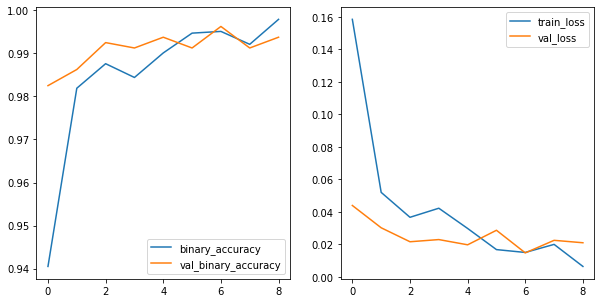

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(historyCNN.history['binary_accuracy'])
ax[0].plot(historyCNN.history['val_binary_accuracy'])
ax[0].legend(['binary_accuracy', 'val_binary_accuracy'])
ax[1].plot(historyCNN.history['loss'])
ax[1].plot(historyCNN.history['val_loss'])
ax[1].legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
modelCNN.evaluate(val_ds)

25/25 [==============================] - 0s 20ms/step - loss: 0.0210 - binary_accuracy: 0.9937


[0.021039746701717377, 0.9937499761581421]

In [ ]:
modelCNN.evaluate(test_ds)

31/31 [==============================] - 2s 53ms/step - loss: 0.0649 - binary_accuracy: 0.9869


[0.06492187082767487, 0.9868951439857483]

While binary classification is a simpler task, the fact this network performs with over 90% accuracy is a testament to how capable of a model CNN is. Using a deep approach over a wide approach like used in the previous homeworks seems to provide a strong benefit here as model nears perfect accuracy. The loss reduction is also quite favorable, demonstrating to what length this model learned its dataset and to the rapid extent in which it did.

### Transfer Learning

For this section, I used VGG16. I originally wanted to use this model, which was part of why I upscaled the images to 224 by 224. The other reason was to ensure they all had the same size.

A [webpage](https://androidkt.com/how-to-use-vgg-model-in-tensorflow-keras/) describing how to use VGG helped me with implementing this section. To use this model with respect to our problem, we must remove the classification layers and prevent the weights in the convolution from being updated.

In [ ]:
IMG_SHAPE = (224, 224, 3)
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# This is the component we need from VGG16
VGG16_MODEL.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# Binary classification problem
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [ ]:
# Building the full model
modelVGG16 = tf.keras.Sequential([
    # Normalize the data as it enters the model
    tf.keras.layers.Rescaling(1./255),
    VGG16_MODEL,
    global_average_layer,
    prediction_layer
])

In [ ]:
modelVGG16.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
historyVGG16 = modelVGG16.fit(train_ds,
                    epochs=100, 
                    steps_per_epoch=2,
                    validation_steps=2,
                    validation_data=val_ds,
                    callbacks = [early_stopping])

Epoch 1/100
2/2 [==============================] - 5s 1s/step - loss: 0.6751 - binary_accuracy: 0.5781 - val_loss: 0.6673 - val_binary_accuracy: 0.6250
Epoch 2/100
2/2 [==============================] - 1s 495ms/step - loss: 0.6714 - binary_accuracy: 0.5625 - val_loss: 0.6553 - val_binary_accuracy: 0.6875
Epoch 3/100
2/2 [==============================] - 1s 502ms/step - loss: 0.6392 - binary_accuracy: 0.7344 - val_loss: 0.6449 - val_binary_accuracy: 0.7188
Epoch 4/100
2/2 [==============================] - 1s 492ms/step - loss: 0.6704 - binary_accuracy: 0.5938 - val_loss: 0.6350 - val_binary_accuracy: 0.7500
Epoch 5/100
2/2 [==============================] - 1s 501ms/step - loss: 0.6772 - binary_accuracy: 0.6406 - val_loss: 0.6268 - val_binary_accuracy: 0.8125
Epoch 6/100
2/2 [==============================] - 1s 509ms/step - loss: 0.6728 - binary_accuracy: 0.6719 - val_loss: 0.6197 - val_binary_accuracy: 0.7812
Epoch 7/100
2/2 [==============================] - 1s 489ms/step - loss: 

In [ ]:
historyVGG16.history

{'loss': [0.6750589609146118,
  0.671410322189331,
  0.6392437219619751,
  0.6704019904136658,
  0.6772112846374512,
  0.6727919578552246,
  0.6368219256401062,
  0.6213096380233765,
  0.611601710319519,
  0.6125839948654175,
  0.618344783782959,
  0.6155465245246887,
  0.6425951719284058,
  0.593771755695343,
  0.5841326713562012,
  0.6024432182312012,
  0.5702751874923706,
  0.5632582902908325,
  0.5970406532287598,
  0.5506283044815063,
  0.5458320379257202,
  0.5456074476242065,
  0.5390031337738037,
  0.566120982170105,
  0.5302414298057556,
  0.554308295249939,
  0.512236475944519,
  0.559330940246582,
  0.510392427444458,
  0.5095854997634888,
  0.5061310529708862,
  0.5088029503822327,
  0.5067266225814819,
  0.5372297763824463,
  0.4910520911216736,
  0.4978294372558594,
  0.48957473039627075,
  0.45678991079330444,
  0.4796568751335144,
  0.47669753432273865,
  0.502264678478241,
  0.49044254422187805,
  0.471443772315979,
  0.48411476612091064,
  0.46945953369140625,
  0.470

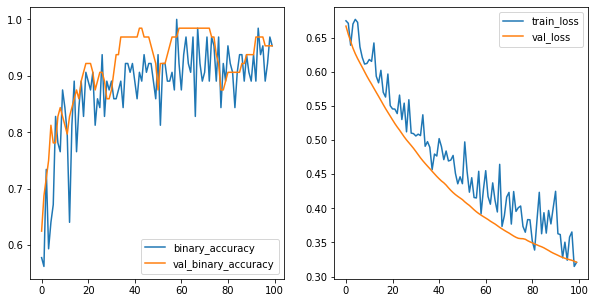

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(historyVGG16.history['binary_accuracy'])
ax[0].plot(historyVGG16.history['val_binary_accuracy'])
ax[0].legend(['binary_accuracy', 'val_binary_accuracy'])
ax[1].plot(historyVGG16.history['loss'])
ax[1].plot(historyVGG16.history['val_loss'])
ax[1].legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
validation_steps = 20

modelVGG16.evaluate(val_ds, steps = validation_steps)

20/20 [==============================] - 3s 166ms/step - loss: 0.3457 - binary_accuracy: 0.9172


[0.34567734599113464, 0.917187511920929]

In [ ]:
modelVGG16.evaluate(test_ds)

31/31 [==============================] - 5s 166ms/step - loss: 0.3401 - binary_accuracy: 0.9435


[0.340139776468277, 0.9435483813285828]

From what we can see, running training takes much longer than it does running the original network. This may be because of how complex the model is or other measures being used in the VGG model to possibly slow it down. One may think its learning is erratic, but it is quite smooth as the loss function is smooth in its descent. There seems to be plenty of noise with the loss and binary accuracy, but despite these, it is clear the model is successful in constantly reducing the ever-important validation loss.

In terms of results, the model's loss is greater than the CNN's, but its accuracy is still over 90%. Part of this may have to do with how the model is structured and its complexity, but I would also argue this model is capable of more. From the validation loss's slope at the last epoch, we can tell it can decrease further. Running for more epochs will further improve the model's binary accuracy, but it would need more time to return this better performance as its descent slows.

### CNN with Data Augmentation

To write this section, I referred to a section on Data Augmentation from [this page](https://cnvrg.io/cnn-tensorflow/). We will randomly flip, rotate, and zoom images that enter the model to boost image diversity. From there, it was repeating what I did for the first part.

In [ ]:
Wdata_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(224, 224, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [ ]:
modelCNNaug = tf.keras.Sequential([
    data_augmentation,
    # Normalize the data as it enters the model
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
modelCNNaug.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
historyCNNaug = modelCNNaug.fit(train_ds,
                       epochs=100,
                       validation_data=val_ds,
                       callbacks=[early_stopping])

Epoch 1/100
313/313 [==============================] - 19s 58ms/step - loss: 0.2103 - binary_accuracy: 0.9214 - val_loss: 0.1995 - val_binary_accuracy: 0.9250
Epoch 2/100
313/313 [==============================] - 18s 58ms/step - loss: 0.1513 - binary_accuracy: 0.9460 - val_loss: 0.0904 - val_binary_accuracy: 0.9737
Epoch 3/100
313/313 [==============================] - 18s 58ms/step - loss: 0.1478 - binary_accuracy: 0.9491 - val_loss: 0.1807 - val_binary_accuracy: 0.9287
Epoch 4/100
313/313 [==============================] - 18s 57ms/step - loss: 0.1160 - binary_accuracy: 0.9568 - val_loss: 0.0811 - val_binary_accuracy: 0.9725
Epoch 5/100
313/313 [==============================] - 18s 57ms/step - loss: 0.1065 - binary_accuracy: 0.9628 - val_loss: 0.0862 - val_binary_accuracy: 0.9688
Epoch 6/100
313/313 [==============================] - 18s 58ms/step - loss: 0.0940 - binary_accuracy: 0.9667 - val_loss: 0.0780 - val_binary_accuracy: 0.9737
Epoch 7/100
313/313 [=========================

In [ ]:
historyCNNaug.history

{'loss': [0.21031086146831512,
  0.15134981274604797,
  0.14779675006866455,
  0.1160152480006218,
  0.1064874529838562,
  0.09399858862161636,
  0.08579399436712265,
  0.0848388671875,
  0.06847675889730453,
  0.06369191408157349,
  0.058268170803785324,
  0.05774858221411705,
  0.05484553799033165],
 'binary_accuracy': [0.9214000105857849,
  0.9459999799728394,
  0.9491000175476074,
  0.9567999839782715,
  0.9628000259399414,
  0.96670001745224,
  0.9682999849319458,
  0.9696000218391418,
  0.9764000177383423,
  0.978600025177002,
  0.9785000085830688,
  0.9807999730110168,
  0.9804999828338623],
 'val_loss': [0.19945009052753448,
  0.09037824720144272,
  0.1806534230709076,
  0.08113327622413635,
  0.0862441286444664,
  0.0779784694314003,
  0.05530049279332161,
  0.05707888305187225,
  0.04378005489706993,
  0.054454684257507324,
  0.042167436331510544,
  0.044689711183309555,
  0.0484733022749424],
 'val_binary_accuracy': [0.925000011920929,
  0.9737499952316284,
  0.9287499785423

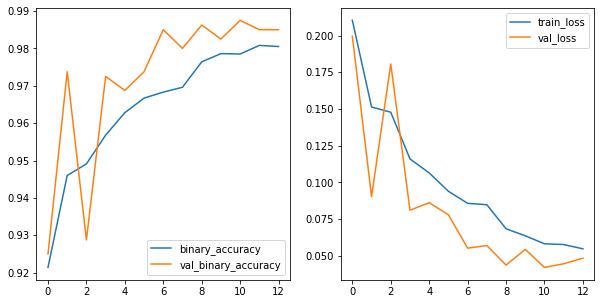

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(historyCNNaug.history['binary_accuracy'])
ax[0].plot(historyCNNaug.history['val_binary_accuracy'])
ax[0].legend(['binary_accuracy', 'val_binary_accuracy'])
ax[1].plot(historyCNNaug.history['loss'])
ax[1].plot(historyCNNaug.history['val_loss'])
ax[1].legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
modelCNNaug.evaluate(val_ds)

25/25 [==============================] - 1s 20ms/step - loss: 0.0485 - binary_accuracy: 0.9850


[0.0484733022749424, 0.9850000143051147]

In [ ]:
modelCNNaug.evaluate(test_ds)

31/31 [==============================] - 1s 20ms/step - loss: 0.0510 - binary_accuracy: 0.9849


[0.051044464111328125, 0.9848790168762207]

With data augmentation, the CNN takes a few more epochs to learn the data than it previously did. This is because the variations are not expected by the model, and it will take more time to learn the different patterns while the augmentation curtails overfitting. When the model did start overfitting, it did so to less of an extent than the original model, and we can tell this not only from the graphs, but also the values outputted by the `history\<model\>.history` cell. This allows for better preservation of the model when it begins overfitting and is cut off by early stopping. Toward the beginning, there is an unusual spike in validation loss and validation binary accuracy. The model quickly recovered and the training equivalents did not reflect as much of a dramatic change, which is what makes me think this may be something with the validation set where the model was not adequately prepared to predict the data it received.

When the model finished, it did so with worse loss and accuracy comparable to the model without data augmentation. Validation loss was larger than before, at 0.04847 to 0.02104, but accuracy is still around 99.0%. On the test set, the augmented version does better with validation loss at 0.05104 to the original's 0.06492, and accuracy for both hovers around 98.5% If given the choice, we would want to use data augmentation because it better prepares the model for new images it may encounter outside what it is trained with, meaning it generalizes better.

### VAE

The implementation for this section came from [TensorFlow documentation](https://www.tensorflow.org/tutorials/generative/cvae) on how to use a VAE.

In [ ]:
(train_fashion, _), (test_fashion, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
train_fashion.shape

(60000, 28, 28)

In [ ]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_fashion_images = preprocess_images(train_fashion)
test_fashion_images = preprocess_images(test_fashion)

In [ ]:
train_size = 60000
batch_size = 32
test_size = 10000

In [ ]:
train_fashion_ds = (tf.data.Dataset.from_tensor_slices(train_fashion_images)
                 .shuffle(train_size).batch(batch_size))
test_fashion_ds = (tf.data.Dataset.from_tensor_slices(test_fashion_images)
                .shuffle(test_size).batch(batch_size))

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_fashion_ds.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -193.13003540039062, time elapse for current epoch: 5.448216438293457


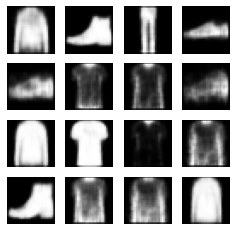

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_fashion_ds:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_fashion_ds:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  IPython.display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

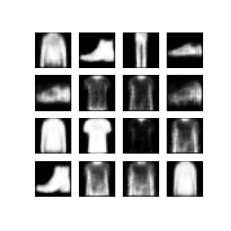

In [ ]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


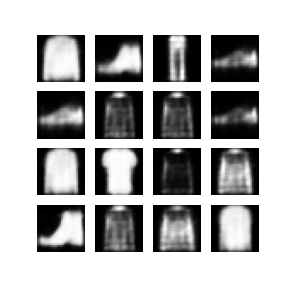

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

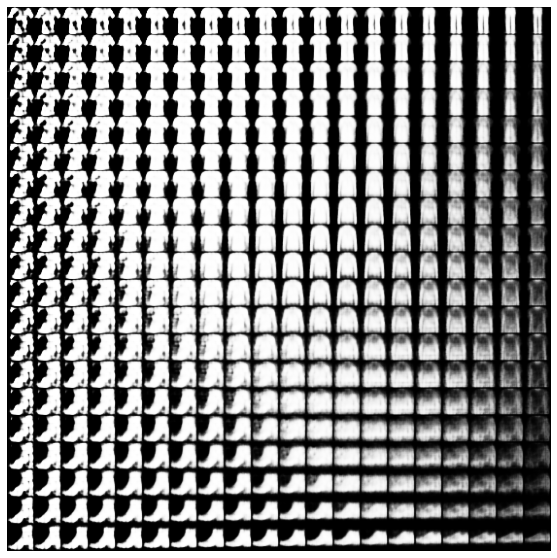

In [ ]:
plot_latent_images(model, 20)

### GAN

The implementation for this section came from [TensorFlow documentation](https://www.tensorflow.org/tutorials/generative/dcgan) on how to use a GAN.

In [ ]:
(X_train_fashion, y_train_fashion), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
X_train_images = X_train_fashion.reshape(X_train_fashion.shape[0], 28, 28, 1).astype('float32')
X_train_norm = (X_train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(X_train_norm).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

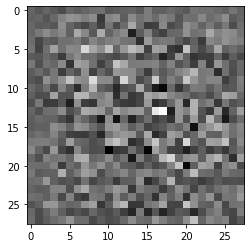

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00238654]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    print(epoch + 1)
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    IPython.display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  IPython.display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

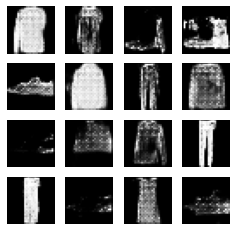

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

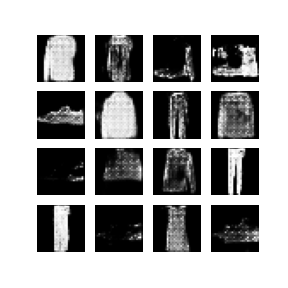

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

I originally tried using the [CIFAR-10 dataset](https://www.tensorflow.org/datasets/catalog/cifar10). At first, this required modifying both the VAE and the GAN structure, which took time understanding how TensorFlow datasets are loaded in compared to how I originally loaded the mask dataset. It also required modifying the structure for both models. When running on CIFAR, the image quality turned out poor, with the VAE returning poor predictions and the GAN returning some predictions. Both featured yellow, blue, and indigo coloring. This could be due to how the models are underfitting on those datasets, and after speaking to Professor Mushtaque, she suggested I note this in my homework. [Here](https://github.com/Zachary-Fernandes/CSCI-6962/blob/main/fernazHW5v3.ipynb) is a link to the aforementioned issue, and it appears under the VAE and GAN sections.

Noting this, I switched to the [Fashion MNIST dataset](https://www.tensorflow.org/datasets/catalog/fashion_mnist) because its data was the closest to the originally-used MNIST dataset with 28 by 28 squares of grayscale pixel data.